[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/s26-06642/blob/main/dsmles/13-model-interpretability/model-interpretability.ipynb)

In [ ]:
! curl -LsSf https://astral.sh/uv/install.sh | sh && \
  uv pip install -q --system "s26-06642 @ git+https://github.com/jkitchin/s26-06642.git"
from pycse.colab import pdf

```{index} model interpretability
```


# Module 13: Model Interpretability

Understanding why models make their predictions.

## Learning Objectives

1. Understand the importance of interpretability
2. Use feature importance from tree-based models
3. Apply SHAP values for model explanation
4. Create partial dependence plots
5. Interpret individual predictions
6. Use symbolic regression to discover interpretable algebraic models

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import xgboost as xgb
import shap
from jaxsr import BasisLibrary, SymbolicRegressor

```{index} global explanation, local explanation
```


## Why Interpretability Matters: The Trust Problem

Machine learning models are increasingly powerful, but power without understanding is dangerous. In chemical engineering, we can't just accept predictions—we need to understand *why*.

### The Interpretability Imperative

| Scenario | Why You Need Interpretability |
|----------|------------------------------|
| Safety-critical decisions | Regulators require explanations |
| Process optimization | Need to know which variables to adjust |
| Model debugging | Unexpected predictions need diagnosis |
| Knowledge discovery | ML can reveal unknown relationships |
| Stakeholder trust | Operators won't use black boxes |

### The Accuracy-Interpretability Tradeoff

Historically, there was a perceived tradeoff:

| Model Type | Interpretability | Accuracy |
|------------|-----------------|----------|
| Linear regression | High | Limited |
| Decision trees | High | Moderate |
| Random forests | Low | High |
| Neural networks | Very low | Very high |

**Modern interpretability tools (SHAP, LIME) break this tradeoff.** We can now explain complex models without sacrificing accuracy.

### Two Types of Explanation

1. **Global**: What features matter overall?
2. **Local**: Why did the model make *this specific* prediction?

Both are important. Global explanations validate the model. Local explanations enable debugging and trust.

In [2]:
# Load reactor yield dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/interpretability_data.csv"
df = pd.read_csv(url)

# Extract features and target
feature_cols = ['temperature', 'pressure', 'catalyst_loading', 'residence_time', 'feed_purity', 'stirrer_speed']
feature_names = feature_cols  # For use in plotting
X = df[feature_cols].values
y = df['yield'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset shape: {df.shape}")
print(f"Features: {feature_cols}")
print(f"Training: {X_train.shape[0]}, Test: {X_test.shape[0]}")
df.head()

Dataset shape: (500, 7)
Features: ['temperature', 'pressure', 'catalyst_loading', 'residence_time', 'feed_purity', 'stirrer_speed']
Training: 400, Test: 100


,temperature,pressure,catalyst_loading,residence_time,feed_purity,stirrer_speed,yield
0,374.908024,14.265073,1.333098,33.549498,0.926171,431.007569,10.073095
1,490.142861,11.185831,2.938554,31.355003,0.924698,405.811118,17.909773
2,446.398788,6.881025,4.428256,6.410314,0.990625,329.411581,5.543681
3,419.731697,16.462105,3.795012,23.768631,0.924955,482.418857,13.652808
4,331.203728,14.009892,4.129525,25.910759,0.927195,180.189806,7.061483


In [3]:
# Train models
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

print(f"Random Forest Test R²: {rf.score(X_test, y_test):.4f}")
print(f"XGBoost Test R²: {xgb_model.score(X_test, y_test):.4f}")

Random Forest Test R²: 0.8018
XGBoost Test R²: 0.7738


```{index} feature importance
```


## Feature Importance: The First Step

Tree-based models (Random Forest, XGBoost) provide built-in feature importance. This is often your first look at what the model learned.

### How It's Calculated

| Method | Measure | Pros | Cons |
|--------|---------|------|------|
| **Impurity-based** (RF) | Total reduction in impurity | Fast, built-in | Biased toward high-cardinality features |
| **Gain-based** (XGBoost) | Average gain when feature is used | Fast, built-in | Can vary between runs |
| **Permutation** | Accuracy drop when feature is shuffled | Model-agnostic, unbiased | Slower, affected by correlations |

### The Limitation

Feature importance tells you **what** matters, but not **how** it matters. Is temperature positively or negatively correlated with yield? Does the effect saturate? These questions require deeper analysis.

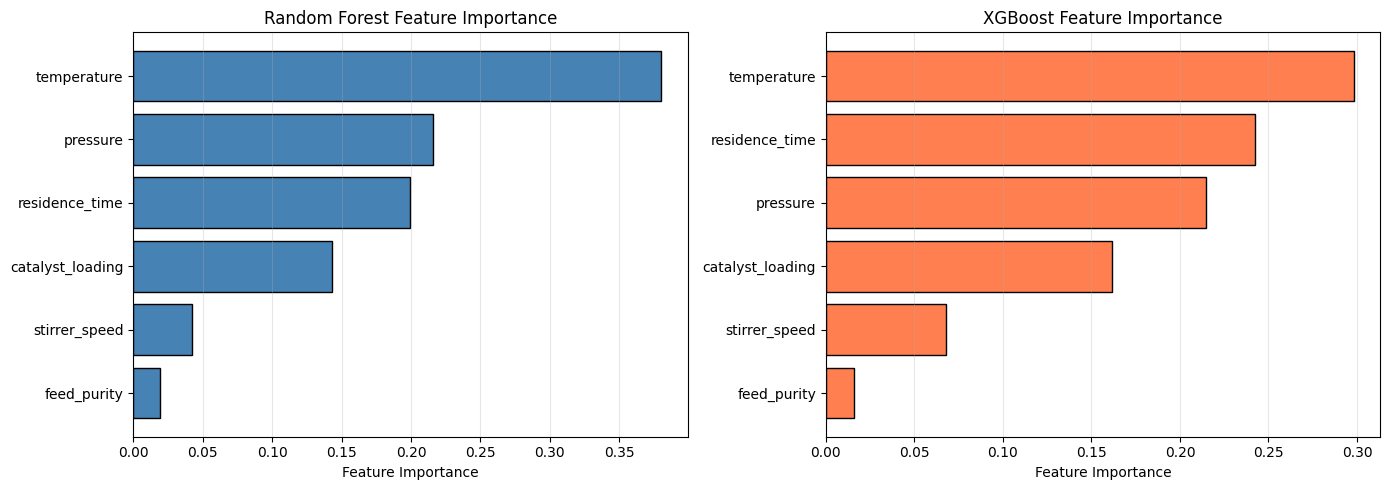

In [4]:
# Feature importance from Random Forest
importance_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
axes[0].barh(importance_rf['Feature'], importance_rf['Importance'], 
             edgecolor='black', color='steelblue')
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Random Forest Feature Importance')
axes[0].grid(True, alpha=0.3, axis='x')

# XGBoost
importance_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)

axes[1].barh(importance_xgb['Feature'], importance_xgb['Importance'], 
             edgecolor='black', color='coral')
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('XGBoost Feature Importance')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

```{index} SHAP values, Shapley values
```


## SHAP Values: The Gold Standard for Interpretability

SHAP (SHapley Additive exPlanations) is based on game theory. It answers: **"How much did each feature contribute to this prediction?"**

### The Shapley Value Concept

Imagine features as players in a game (predicting the target). The Shapley value assigns credit fairly by considering all possible combinations of features and averaging each feature's marginal contribution.

### Why SHAP Is Special

1. **Consistency**: If a feature's contribution increases, its SHAP value won't decrease
2. **Local accuracy**: SHAP values sum to the difference between prediction and baseline
3. **Theoretical foundation**: Based on 60+ years of game theory research
4. **Signs and magnitudes**: Positive SHAP = pushed prediction up; magnitude = how much

### Interpreting SHAP Plots

| Plot Type | What It Shows | Use For |
|-----------|---------------|---------|
| Summary | Feature importance + direction + distribution | Global overview |
| Waterfall | Single prediction breakdown | Explaining individual decisions |
| Dependence | Feature effect vs feature value | Understanding relationships |
| Force | Real-time feature contributions | Interactive exploration |

In [5]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Each row: SHAP value for each feature for one prediction")

SHAP values shape: (100, 6)
Each row: SHAP value for each feature for one prediction


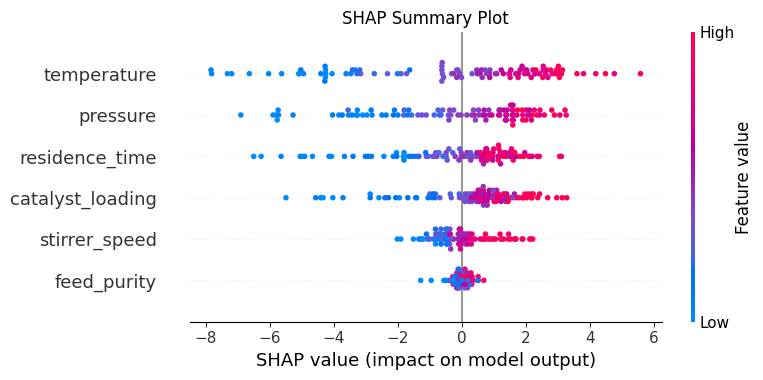

In [6]:
# Summary plot: global feature importance with direction
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()

```{index} SHAP summary plot
```


**Reading the SHAP summary plot:**

This is one of the most information-dense visualizations in ML. Here's how to read it:

- **Each row** is a feature, sorted by importance (most important at top)
- **Each point** is one sample from the test set
- **X-axis** shows the SHAP value (contribution to prediction)
- **Color** shows the feature value (red=high, blue=low)

**What we see:**
- **temperature**: Red points (high temp) have positive SHAP values → higher temperature increases predicted yield
- **catalyst_loading**: Same pattern—more catalyst increases yield
- **feed_purity**: Red points on the right → higher purity increases yield
- **pressure**: Positive relationship, but less spread than temperature
- **residence_time**: Smaller effect, but still positive
- **stirrer_speed**: Minimal effect (narrow horizontal spread)

**Physical validation**: All effects are positive (more of each variable increases yield), which matches our synthetic data and general chemical intuition. If we saw negative effects for temperature or catalyst, we'd question the model or our data!

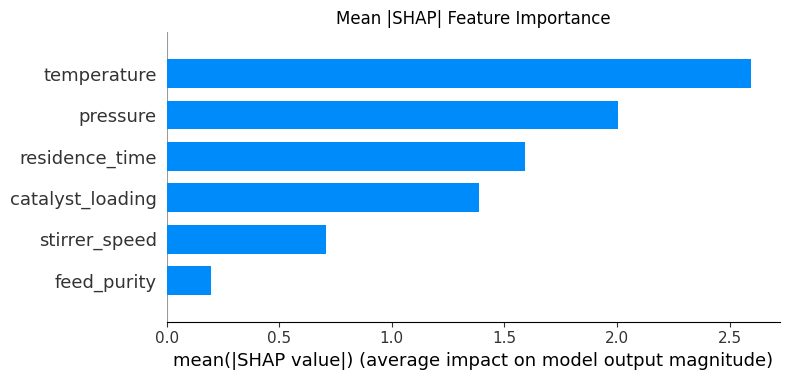

In [7]:
# Bar plot of mean absolute SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, 
                  plot_type='bar', show=False)
plt.title('Mean |SHAP| Feature Importance')
plt.tight_layout()
plt.show()

```{index} waterfall plot
```


## Explaining Individual Predictions

In [8]:
# Explain a single prediction
sample_idx = 0
sample = X_test[sample_idx]
prediction = xgb_model.predict([sample])[0]
actual = y_test[sample_idx]

print(f"Sample features:")
for name, val in zip(feature_names, sample):
    print(f"  {name}: {val:.2f}")
print(f"\nPredicted yield: {prediction:.2f}")
print(f"Actual yield: {actual:.2f}")

Sample features:
  temperature: 428.66
  pressure: 9.61
  catalyst_loading: 1.45
  residence_time: 41.09
  feed_purity: 0.94
  stirrer_speed: 212.99

Predicted yield: 9.87
Actual yield: 11.37


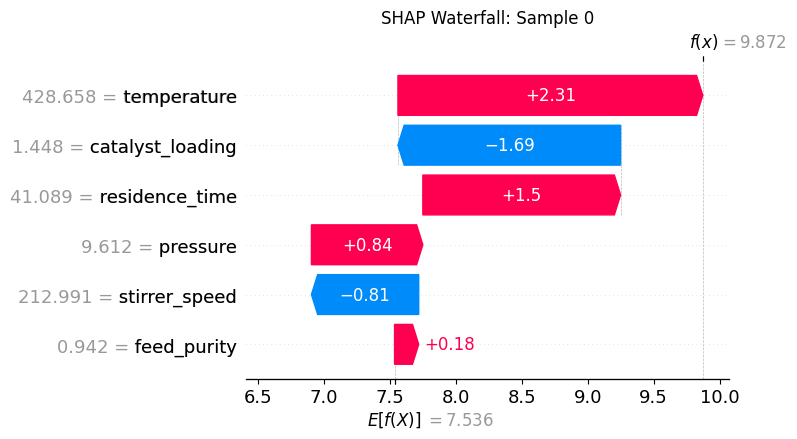

In [9]:
# Waterfall plot for single prediction
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_test[sample_idx],
    feature_names=feature_names
), show=False)
plt.title(f'SHAP Waterfall: Sample {sample_idx}')
plt.tight_layout()
plt.show()

In [10]:
# Force plot for single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_idx], 
                X_test[sample_idx], feature_names=feature_names)

## SHAP Dependence Plots

How does a feature affect predictions across all samples?

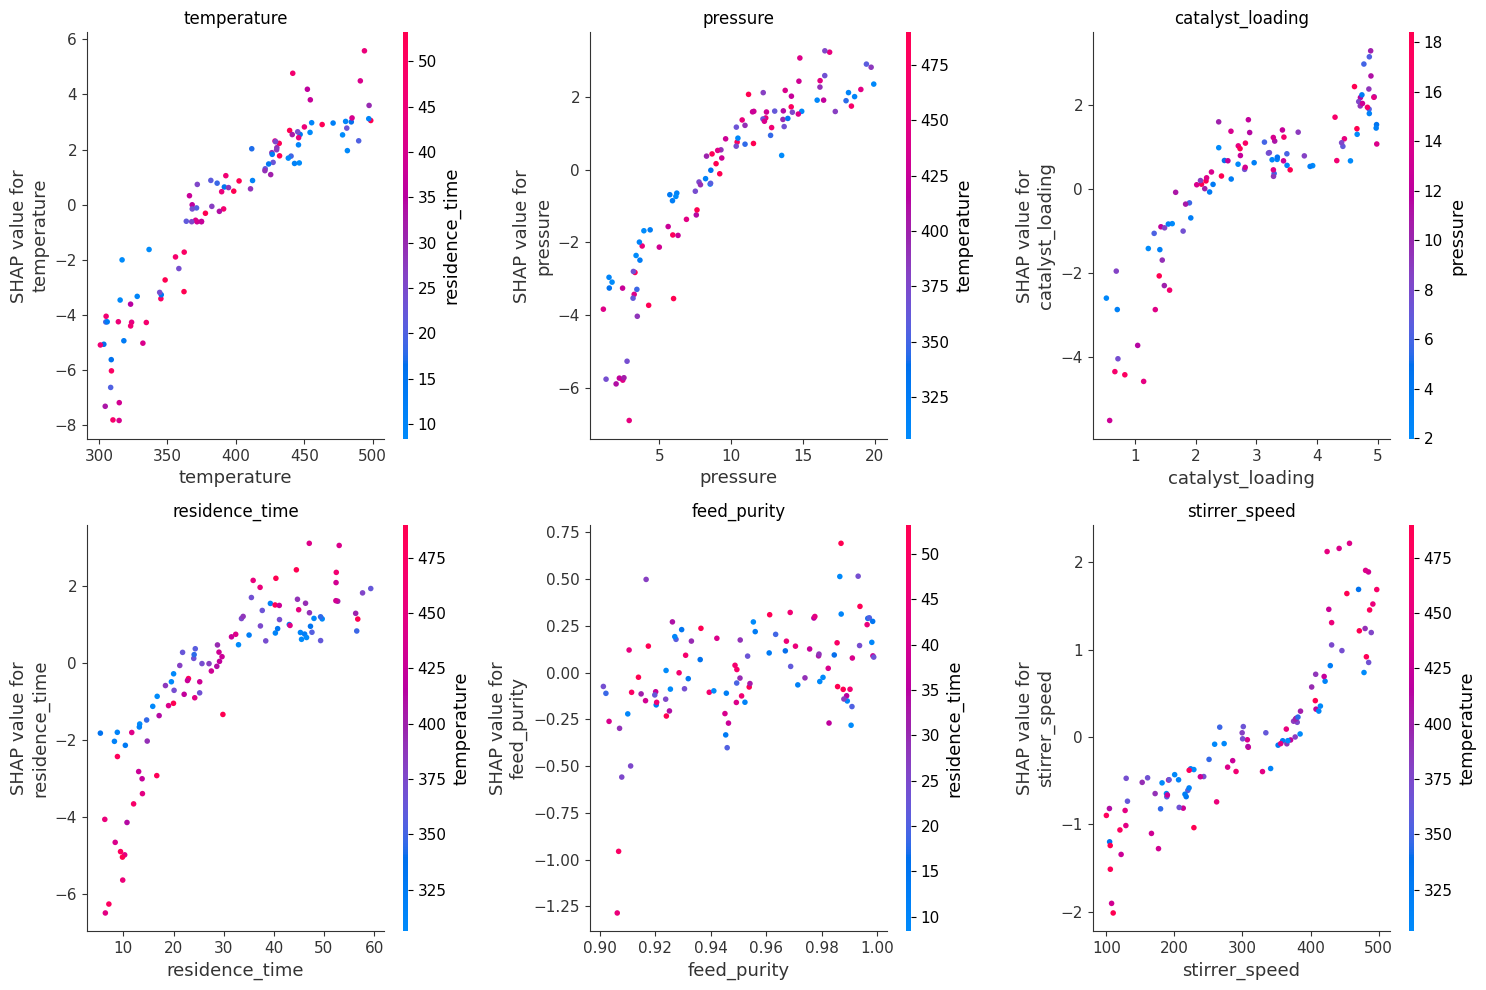

In [11]:
# Dependence plots for key features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (idx, name) in zip(axes.flat, enumerate(feature_names)):
    shap.dependence_plot(idx, shap_values, X_test, 
                         feature_names=feature_names, ax=ax, show=False)
    ax.set_title(f'{name}')

plt.tight_layout()
plt.show()

```{index} partial dependence plot, PDP
```


## Partial Dependence Plots: The Marginal Effect

Partial Dependence Plots (PDPs) show how a feature affects predictions **on average**, while marginalizing over other features.

### How It Works

1. Pick a feature (e.g., temperature)
2. Create a grid of values for that feature
3. For each grid value, replace all samples' temperature with that value
4. Average the predictions
5. Plot average prediction vs temperature

### PDPs vs SHAP Dependence

| Aspect | PDP | SHAP Dependence |
|--------|-----|-----------------|
| Shows | Marginal effect | Actual contribution |
| Interactions | Hidden (averaged out) | Visible (colored by interaction) |
| Interpretation | "If we set T=400, yield is ~X" | "For samples where T=400, T contributed ~X" |

### 2D PDPs: Interaction Effects

Two-feature PDPs reveal interactions. If the effect of temperature depends on pressure, the 2D plot will show it—something hidden in 1D plots.

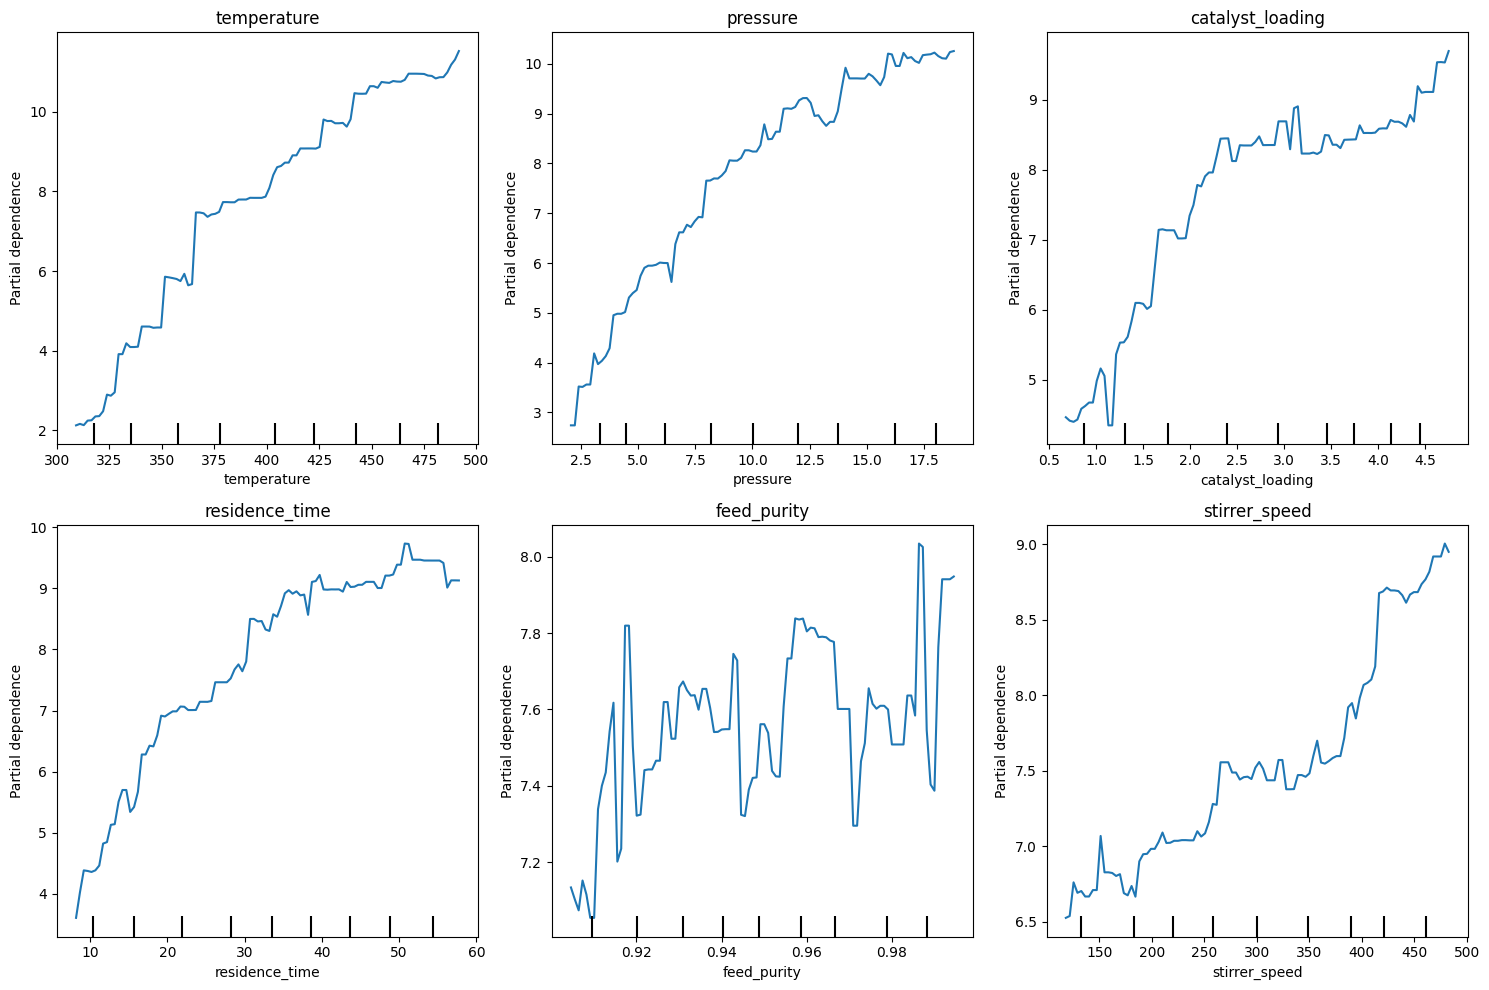

In [12]:
# Partial dependence plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, idx in zip(axes.flat, range(len(feature_names))):
    PartialDependenceDisplay.from_estimator(
        xgb_model, X_train, [idx], 
        feature_names=feature_names, ax=ax
    )
    ax.set_title(feature_names[idx])

plt.tight_layout()
plt.show()

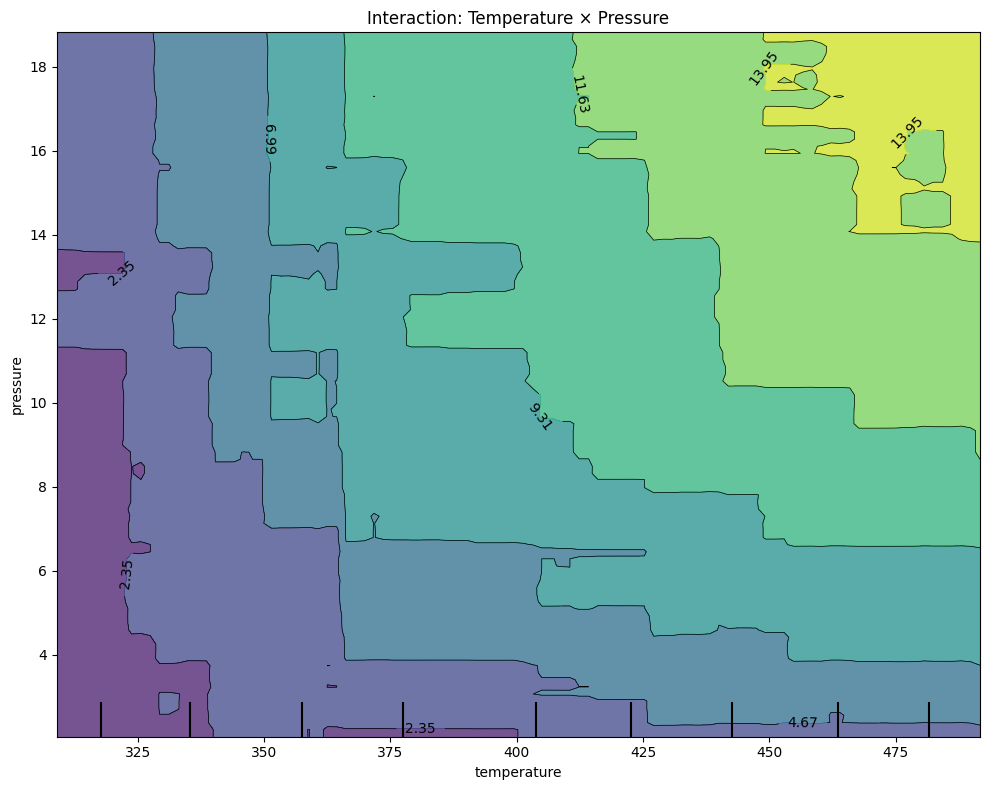

In [13]:
# 2D interaction plot: temperature vs pressure
fig, ax = plt.subplots(figsize=(10, 8))

PartialDependenceDisplay.from_estimator(
    xgb_model, X_train, [(0, 1)],  # temperature and pressure
    feature_names=feature_names, ax=ax
)
ax.set_title('Interaction: Temperature × Pressure')
plt.tight_layout()
plt.show()

## Comparing Model Interpretations

In [14]:
# Compare feature importance methods
# 1. Impurity-based (RF)
# 2. Gain-based (XGBoost)
# 3. SHAP-based

shap_importance = np.abs(shap_values).mean(axis=0)

comparison = pd.DataFrame({
    'Feature': feature_names,
    'RF Impurity': rf.feature_importances_,
    'XGB Gain': xgb_model.feature_importances_,
    'SHAP': shap_importance / shap_importance.sum()  # Normalize
})

# Normalize all for comparison
for col in ['RF Impurity', 'XGB Gain', 'SHAP']:
    comparison[col] = comparison[col] / comparison[col].sum()

print("Feature Importance Comparison (normalized):")
print(comparison.round(3).to_string(index=False))

Feature Importance Comparison (normalized):
         Feature  RF Impurity  XGB Gain  SHAP
     temperature        0.380     0.298 0.306
        pressure        0.216     0.214 0.236
catalyst_loading        0.143     0.162 0.164
  residence_time        0.199     0.242 0.188
     feed_purity        0.019     0.016 0.023
   stirrer_speed        0.042     0.068 0.084


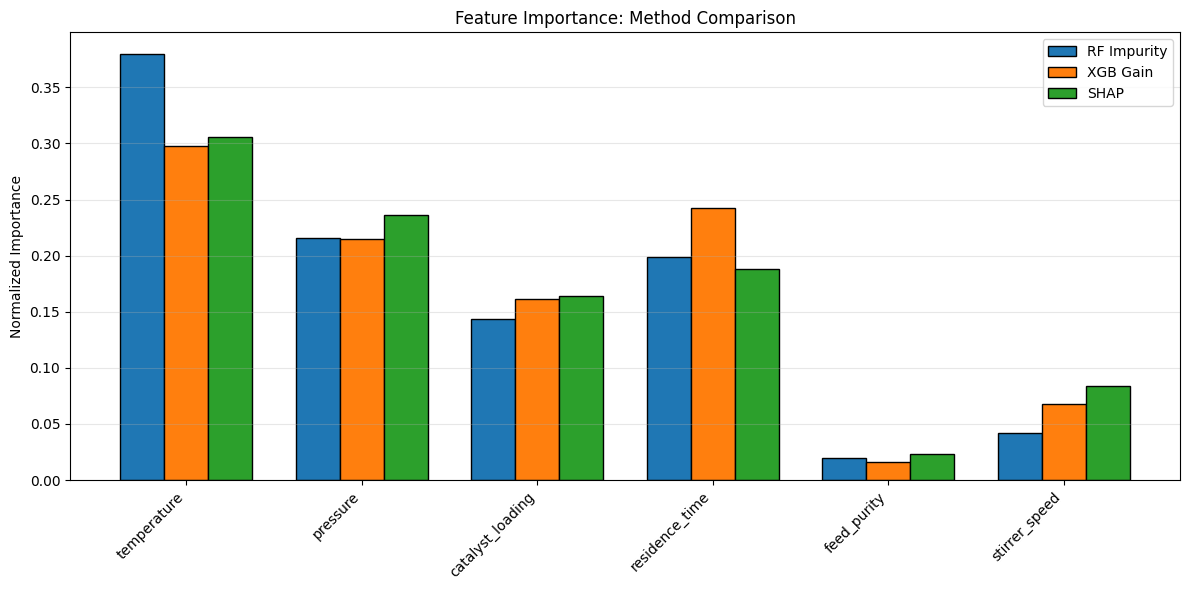

In [15]:
# Visualize comparison
comparison_melted = comparison.melt(id_vars='Feature', var_name='Method', value_name='Importance')

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(feature_names))
width = 0.25

ax.bar(x - width, comparison['RF Impurity'], width, label='RF Impurity', edgecolor='black')
ax.bar(x, comparison['XGB Gain'], width, label='XGB Gain', edgecolor='black')
ax.bar(x + width, comparison['SHAP'], width, label='SHAP', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_ylabel('Normalized Importance')
ax.set_title('Feature Importance: Method Comparison')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Domain Validation

Check if model insights match domain knowledge.

In [16]:
# Expected relationships (from process knowledge):
# 1. Temperature: Positive effect (Arrhenius)
# 2. Pressure: Positive effect (Le Chatelier)
# 3. Catalyst: Positive effect (saturation curve)
# 4. Residence time: Positive effect (reaction completion)
# 5. Feed purity: Positive effect (less side reactions)
# 6. Stirrer speed: Minor positive effect (mixing)

# Check SHAP dependence trends
print("Domain Validation:")
print("="*50)

for idx, name in enumerate(feature_names):
    correlation = np.corrcoef(X_test[:, idx], shap_values[:, idx])[0, 1]
    direction = "Positive" if correlation > 0 else "Negative"
    print(f"{name}: {direction} effect (r = {correlation:.3f})")

Domain Validation:
temperature: Positive effect (r = 0.928)
pressure: Positive effect (r = 0.906)
catalyst_loading: Positive effect (r = 0.854)
residence_time: Positive effect (r = 0.846)
feed_purity: Positive effect (r = 0.440)
stirrer_speed: Positive effect (r = 0.900)


```{index} symbolic regression
```


## Symbolic Regression: Interpretability by Design

So far, we've used post-hoc methods (SHAP, PDPs, feature importance) to explain black-box models. But what if the model *itself* was the explanation?

**Symbolic regression** searches for algebraic equations that fit the data. Instead of a Random Forest with hundreds of trees, you get a human-readable formula like:

$$y = 0.03\,T + 0.5\,P + 1.2\,C_{cat} + \ldots$$

This is the approach advocated by [Rudin (2019)](https://www.nature.com/articles/s42256-019-0048-x) in our Recommended Reading: for high-stakes decisions, use inherently interpretable models rather than explaining black boxes after the fact.

### How jaxsr Works

[jaxsr](https://kitchingroup.cheme.cmu.edu/jaxsr/intro.html) builds a **basis library** of candidate terms (linear, polynomial, interaction) and uses sparse optimization to select a small subset that best explains the data. The result is a compact algebraic expression.

### Post-hoc Explanation vs Inherently Interpretable

| Aspect | Post-hoc (SHAP on RF/XGB) | Inherently Interpretable (Symbolic Regression) |
|--------|---------------------------|------------------------------------------------|
| Model | Black-box | Algebraic equation |
| Explanation | Approximate, after the fact | Exact, built-in |
| Calculus/analysis | Not possible | Derivatives, optima, sensitivity |
| Accuracy | Often higher | May be slightly lower |
| Regulatory | "We explained the black box" | "Here is the equation" |

In [ ]:
# Build basis library and fit symbolic regression model
basis = BasisLibrary(len(feature_cols), feature_names=feature_cols)
basis.add_constant()
basis.add_linear()
basis.add_polynomials(max_degree=3)
basis.add_interactions()

sr = SymbolicRegressor(basis, max_terms=8, strategy="greedy_forward",
                       information_criterion="bic")
sr.fit(X_train, y_train)

print("Discovered expression:")
print(sr.expression_)
print()

# Evaluate symbolic regression
from sklearn.metrics import r2_score, mean_squared_error

y_pred_sr = sr.predict(X_test)
r2_sr = r2_score(y_test, y_pred_sr)
mse_sr = mean_squared_error(y_test, y_pred_sr)

print(f"Symbolic Regression  R² = {r2_sr:.4f},  MSE = {mse_sr:.4f}")
print(f"Random Forest        R² = {rf.score(X_test, y_test):.4f}")
print(f"XGBoost              R² = {xgb_model.score(X_test, y_test):.4f}")

# Actual vs predicted comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, y_pred) in zip(axes, [
    ("Symbolic Regression", y_pred_sr),
    ("Random Forest", rf.predict(X_test)),
    ("XGBoost", xgb_model.predict(X_test)),
]):
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolor='k', linewidth=0.5)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    ax.plot(lims, lims, 'r--', linewidth=2, label='Perfect')
    ax.set_xlabel('Actual Yield')
    ax.set_ylabel('Predicted Yield')
    ax.set_title(name)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpreting the Symbolic Model

The equation above is the complete model -- there is no hidden complexity. Every term is readable, and we can reason about the model directly:

- **Which features appear?** The selected terms reveal what the model considers important, consistent with our SHAP analysis above.
- **What are the functional forms?** Linear terms indicate proportional effects; polynomial and interaction terms reveal nonlinearities and synergies between variables.
- **Calculus is possible.** Unlike Random Forest or XGBoost, we can take derivatives of this equation to find optima, compute sensitivities ($\partial y / \partial T$), and analyze the model mathematically.

### The Tradeoff

The symbolic model may have a slightly lower R² than the tree-based models, but it offers something they cannot: **complete transparency**. You can write this equation in a report, hand it to a process engineer, or embed it in a control system -- no ML library required.

### When to Use Each Approach

| Scenario | Recommended Approach |
|----------|---------------------|
| Highest predictive accuracy needed | Tree ensemble + SHAP explanation |
| Regulatory or safety-critical setting | Symbolic regression (inherently interpretable) |
| Need to optimize process variables analytically | Symbolic regression (calculus-friendly) |
| Exploratory analysis, many features | Tree ensemble + feature importance / SHAP |
| Embedding model in simple control hardware | Symbolic regression (just an equation) |

In [17]:
%pip install -q jupyterquiz
from jupyterquiz import display_quiz

display_quiz("https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/13-model-interpretability/quizzes/model-interpretability-quiz.json")

/bin/bash: pip: command not found


<IPython.core.display.Javascript object>

## Recommended Reading

These resources explore model interpretability and explainable AI:

1. **[SHAP Documentation](https://shap.readthedocs.io/en/latest/)** - Official documentation for the SHAP library. Includes tutorials on TreeExplainer, DeepExplainer, and various plot types.

2. **[Interpretable Machine Learning (Christoph Molnar)](https://christophm.github.io/interpretable-ml-book/)** - A free online book covering all major interpretability methods including SHAP, LIME, partial dependence, and feature importance. The definitive reference.

3. **[A Unified Approach to Interpreting Model Predictions (Lundberg & Lee, NeurIPS 2017)](https://papers.nips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html)** - The original SHAP paper introducing Shapley values for ML interpretation. Provides theoretical foundation for SHAP values.

4. **[Partial Dependence Plots (Scikit-learn)](https://scikit-learn.org/stable/modules/partial_dependence.html)** - Official documentation on PDPs and Individual Conditional Expectation (ICE) plots. Includes examples and interpretation guidance.

5. **[Stop Explaining Black Box Models for High Stakes Decisions (Rudin, Nature Machine Intelligence 2019)](https://www.nature.com/articles/s42256-019-0048-x)** - Provocative paper arguing for inherently interpretable models over post-hoc explanations. Important perspective on when interpretability is essential.

6. **[jaxsr: JAX-based Symbolic Regression](https://kitchingroup.cheme.cmu.edu/jaxsr/intro.html)** - A library for discovering interpretable mathematical expressions from data using sparse optimization. Produces human-readable equations with uncertainty quantification.

## Summary: The Interpretability Toolkit

### Method Comparison

| Method | Speed | Insight Type | Best For |
|--------|-------|--------------|----------|
| Feature importance | Fast | Global ranking | Quick overview |
| SHAP summary | Moderate | Global + direction | Detailed analysis |
| SHAP waterfall | Fast | Single prediction | Debugging, explanation |
| Dependence plots | Fast | Feature relationships | Understanding effects |
| Partial dependence | Moderate | Marginal effects | Smooth trends |
| 2D PDP | Slow | Interactions | Discovering dependencies |
| Symbolic regression | Moderate | Algebraic equation | Inherently interpretable models |

### The Interpretation Workflow

1. **Start with feature importance**: Quick overview of what matters
2. **Use SHAP summary**: See direction and distribution of effects
3. **Check domain validity**: Do the effects make physical sense?
4. **Debug with waterfall**: Explain unexpected predictions
5. **Explore with dependence plots**: Understand nonlinear relationships
6. **Consider symbolic regression**: Get a transparent, analyzable equation

### Key Takeaways

1. **Interpretability enables trust**: Stakeholders need to understand why
2. **SHAP is theoretically grounded**: Use it as your primary tool
3. **Validate against domain knowledge**: Models should make sense
4. **Local + global**: You need both types of explanation
5. **Different methods, different insights**: Use multiple approaches
6. **Symbolic regression offers inherent interpretability**: Sometimes the best explanation is the model itself

### Common Pitfalls

- Trusting feature importance without checking direction of effects
- Ignoring interactions (use 2D PDPs and SHAP dependence)
- Not validating against domain knowledge
- Over-interpreting small differences in importance
- Forgetting that correlation ≠ causation (even with SHAP)

## Course Conclusion

You've now learned a complete toolkit for data science in chemical engineering:

| Module | Skills |
|--------|--------|
| NumPy & Pandas | Data manipulation |
| Dimensionality reduction | PCA, t-SNE, UMAP |
| Regression | Linear, regularized, nonlinear |
| Ensemble methods | Random Forest, XGBoost |
| Clustering | K-means, hierarchical, DBSCAN |
| Uncertainty | pycse, Gaussian Processes |
| Interpretability | SHAP, partial dependence, symbolic regression |

**Now apply these tools to your own problems!** The best way to learn is by doing. Start with a real dataset from your research or industry, and work through the analysis pipeline we've covered.

---

## The Catalyst Crisis: Chapter 13 - "The Reveal"

*A story about interpretability, communication, and the power of explanation*

---

The boardroom was larger than Alex expected. Twelve executives around a polished table, the ChemCorp logo glowing on the wall screen. Frank Morrison sat near the end, arms crossed, but with something that might have been pride in his expression.

"Thank you for your time," Professor Pipeline began. "The Data Academy team has spent a semester investigating the catalyst crisis. Alex Chen will present the findings."

Alex took a breath and clicked to the first slide.

"Eighteen months ago, ChemCorp's flagship reactor started producing inconsistent batches. Good yield, bad yield, no apparent pattern." She advanced to the t-SNE plot. "We found the pattern."

She walked them through the journey. Missing data that wasn't random. An outlier that wasn't an error. Dimensions collapsing from two hundred to five. Models that predicted well but couldn't explain why.

"The answer came when we stopped asking 'what predicts yield' and started asking 'why do certain batches fail.'" She pulled up the SHAP values—the interpretability layer that explained individual predictions.

"This is a single batch that failed." The waterfall chart showed features pushing the prediction up and down. "Temperature contributed positively—it was in a good range. Pressure, neutral. But catalyst age pushed the prediction strongly negative. This batch used catalyst from Lot 7,392—Cluster 3 material, manufactured in April of last year."

She clicked through more examples. The pattern was consistent. Every failed batch had the same story: catalyst from the March-August window, trace metal ratios slightly off, surface area slightly low. Each property within spec. The combination, deadly.

"We traced it back to your supplier." Final slide. "They changed their calcination process in February. The change was undocumented and unannounced. The new process produces catalyst that meets all specifications individually but performs poorly in your reactor."

The VP of Operations spoke first. "You're certain?"

"We presented this analysis to the supplier yesterday. They confirmed the process change." Alex allowed herself a small smile. "They're implementing corrective action."

Silence around the table. Then, slowly, nods. The skepticism she'd sensed when she walked in was dissolving.

Frank Morrison spoke up. "I've been running reactors for thirty years. I know this plant better than anyone." He paused. "I couldn't have found this. Not without the data analysis. Not without the modeling." He looked at Alex. "I was wrong to be skeptical."

"You were right to be skeptical," Alex said. "Until we could explain why the model was right, skepticism was reasonable. Predictions without explanations are just black boxes. You needed to understand."

As the meeting wrapped up, Professor Pipeline caught Alex's eye. The smallest of nods.

Later, at the Data Academy mystery board, Alex removed the sticky notes one by one. Eighteen clues, accumulated over a semester, now resolved into a single answer.

She saved the last note for her notebook: **The mystery wasn't in the data. It was in what we assumed we already knew.**

---

## Epilogue

Three weeks after the presentation, Alex sat in the graduate student lounge, coffee in hand. The semester was over. The mystery was solved. And yet...

Maya appeared, dropping into the chair across from her. "You look thoughtful."

"I keep thinking about what's next." Alex turned her cup in her hands. "This was one problem. One reactor. There are thousands of problems like this—hidden patterns, unexplained failures, data no one's asking the right questions about."

"So you want to keep doing this?"

"I want to get better at it." Alex thought about the semester—the struggles, the breakthroughs, the late nights and unexpected connections. "I came back to school because I wanted to understand, not just apply. I think I understand a little more now."

Jordan and Sam joined them, the team reuniting one last time.

"Frank Morrison called me," Sam said. "He wants to know if we can consult on another plant."

Maya laughed. "Didn't he hate us at first?"

"He hated what he didn't understand." Alex smiled. "Once he understood, he became an advocate. That's usually how it works."

She looked around at her team—the CS expert who learned chemistry, the pharma veteran who found his voice, the star student who discovered humility. They'd started as strangers. They'd become colleagues. Maybe friends.

"Whatever's next," Alex said, "we should do it together."

The Data Academy had one final update to her profile: *Rank: Data Scientist*

But that wasn't the real accomplishment. The real accomplishment was simpler: she'd walked into a room full of skeptics, with data and models and uncertainty, and she'd helped them see what they'd been missing.

That was the work. And it was only beginning.

---

*End of The Catalyst Crisis*

---

**Congratulations on completing Data Science and Machine Learning in Chemical Engineering!** You've learned the same tools Alex and her team used to solve the Catalyst Crisis. Now it's your turn to find the patterns hiding in your own data.